In [1]:
%matplotlib inline

## Import Package

In [2]:
from __future__ import print_function

import os
import time
import numpy as np
import torch
import torch.tensor
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import utils
from net import Net, Vgg16

print(torch.__version__)

0.4.1


In [3]:
mode = 'evaluate'#'train'

# ----- fixed -----
DATASET_FOLDER = 'dataset/'
STYLE_FOLDER = 'images/9styles/'
SAVE_MODEL_DIR = 'models/'
VGG_DIR = 'models/'
# ----- fixed -----

# ----- training parameters -----
EPOCHS = 2
IMAGE_SIZE = 256
FILTER_CHANNEL = 128
LEARNING_RATE = 1e-3
BATCH_SIZE = 4
CONT_WEIGHT = 1e5
STYLE_WEIGHT = 1e10
RESUME = None #''
CONT_FEATURE = 1 #[relu1_2, relu2_2, relu3_3, relu4_3]
# ----- training parameters -----

# ----- evaluate parameters -----
EV_MODEL_DIR = 'models/Final_epoch_4_Thu_Dec_13_06:56:56_2018_1.0_5.0.model'
EV_CONT_IMG = 'images/content/Batman Eternal (2014-) 010-004.jpg'
EV_STYLE_IMG = STYLE_FOLDER + 'starry_night.jpg'
EV_OUTPUT_IMG = 'output/starry_night_1_Final_epoch_4_Thu_Dec_13_06:56:56_2018_1.0_5.0.model.png'
# ----- evaluate parameters -----


## Select Device (CPU/GPU)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Train Model

In [5]:
def train():
    check_point_path = ''

    np.random.seed(42)
    torch.manual_seed(42)
    
    transform = transforms.Compose([transforms.Scale(IMAGE_SIZE),
                                    transforms.CenterCrop(IMAGE_SIZE),
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x.mul(255))])

    train_dataset = datasets.ImageFolder(DATASET_FOLDER, transform)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

    style_model = Net(ngf=FILTER_CHANNEL, dv=device).to(device)
    if RESUME is not None:
        print('Resuming, initializing using weight from {}.'.format(RESUME))
        style_model.load_state_dict(torch.load(RESUME))
    print(style_model)
    optimizer = Adam(style_model.parameters(), LEARNING_RATE)
    mse_loss = torch.nn.MSELoss()

    vgg = Vgg16().to(device)
    utils.init_vgg16(VGG_DIR)
    vgg.load_state_dict(torch.load(os.path.join(VGG_DIR, "vgg16.weight")))
    #vgg.to(device)

    style_loader = utils.StyleLoader(STYLE_FOLDER, IMAGE_SIZE, device)
    
    tbar = tqdm(range(EPOCHS))
    for e in tbar:
        style_model.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()
            x = Variable(utils.preprocess_batch(x)).to(device)

            style_v = style_loader.get(batch_id)
            style_model.setTarget(style_v)

            style_v = utils.subtract_imagenet_mean_batch(style_v, device)
            features_style = vgg(style_v)
            gram_style = [utils.gram_matrix(y) for y in features_style]

            y = style_model(x)
            xc = Variable(x.data.clone())

            y = utils.subtract_imagenet_mean_batch(y, device)
            xc = utils.subtract_imagenet_mean_batch(xc, device)

            features_y = vgg(y)
            features_xc = vgg(xc)

            f_xc_c = Variable(features_xc[CONT_FEATURE].data, requires_grad=False)

            content_loss = CONT_WEIGHT * mse_loss(features_y[CONT_FEATURE], f_xc_c)

            style_loss = 0.
            for m in range(len(features_y)):
                gram_y = utils.gram_matrix(features_y[m])
                gram_s = Variable(gram_style[m].data, requires_grad=False).repeat(BATCH_SIZE, 1, 1, 1)
                style_loss += STYLE_WEIGHT * mse_loss(gram_y.unsqueeze_(1), gram_s[:n_batch, :, :])

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss.data[0]
            agg_style_loss += style_loss.data[0]

            if (batch_id + 1) % 100 == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                                agg_content_loss / (batch_id + 1),
                                agg_style_loss / (batch_id + 1),
                                (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                tbar.set_description(mesg)

            
            if (batch_id + 1) % (100) == 0:
                # save model
                style_model.eval()
                style_model.cpu()
                save_model_filename = "Epoch_" + str(e) + "iters_" + str(count) + "_" + \
                    str(time.ctime()).replace(' ', '_') + "_" + str(
                    CONT_WEIGHT) + "_" + str(STYLE_WEIGHT) + ".model"
                save_model_path = os.path.join(SAVE_MODEL_DIR, save_model_filename)
                torch.save(style_model.state_dict(), save_model_path)
                if check_point_path:
                    os.remove(check_point_path)
                check_point_path = save_model_path
                style_model.train()
                style_model.cuda()
                tbar.set_description("\nCheckpoint, trained model saved at", save_model_path)

    # save model
    style_model.eval()
    style_model.cpu()
    save_model_filename = "Final_epoch_" + str(EPOCHS) + "_" + \
        str(time.ctime()).replace(' ', '_') + "_" + str(
        CONT_WEIGHT) + "_" + str(STYLE_WEIGHT) + ".model"
    save_model_path = os.path.join(SAVE_MODEL_DIR, save_model_filename)
    torch.save(style_model.state_dict(), save_model_path)
    if check_point_path:
        os.remove(check_point_path)

    print("\nDone, trained model saved at", save_model_path)


In [6]:
def evaluate(model_dir, c_img, s_img, img_size, out_img):
    content_image = utils.tensor_load_rgbimage(c_img)#, size=img_size, keep_asp=True)
    content_image = content_image.unsqueeze(0).to(device)
    style = utils.tensor_load_rgbimage(s_img)#, size=img_size)
    style = style.unsqueeze(0)    
    style = utils.preprocess_batch(style).to(device)

    style_model = Net(ngf=FILTER_CHANNEL, dv=device).to(device)
    style_model.load_state_dict(torch.load(model_dir), False)
    
    style_v = Variable(style)

    content_image = Variable(utils.preprocess_batch(content_image))
    style_model.setTarget(style_v)

    output = style_model(content_image)
    #output = utils.color_match(output, style_v)
    utils.tensor_save_bgrimage(output.data[0], out_img)
    print ('Done')
    return output.data[0]

In [7]:
def imshow(tensor, title=None):
    plt.figure()
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    img = tensor.clone().cpu().clamp(0, 255).detach().numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

## Select Status (train/optimize/evaluate)

Evaluating...


/usr/local/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Done


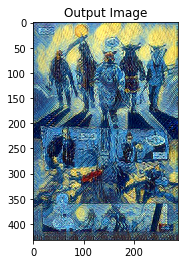

In [8]:
if mode == 'train':
    print ('Training...')
    train()
    
elif mode == 'evaluate':
    print ('Evaluating...')
    out = evaluate(EV_MODEL_DIR, EV_CONT_IMG, EV_STYLE_IMG, IMAGE_SIZE, EV_OUTPUT_IMG)
    imshow(out, title='Output Image')

else:
    print ('Error!!!!!!!')

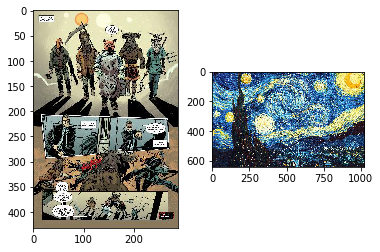

In [9]:
if mode == 'evaluate':
    img=mpimg.imread(EV_CONT_IMG)
    img1=mpimg.imread(EV_STYLE_IMG)

    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img)
    axarr[1].imshow(img1)

    plt.show()